In [284]:
import pandas as pd
import os
import sys
import pickle
import numpy as np

In [285]:
train_points = pd.read_csv("train_gd1.csv")
train_points = train_points[["ra", "dec", "pmra", "pmdec", "g_bp", "g_rp", "g", "label"]]

In [286]:
test_points = pd.read_csv("test_gd1.csv")
test_points = test_points[["ra", "dec", "pmra", "pmdec", "g_bp", "g_rp", "g", "label"]]

In [287]:
stream_train = train_points[train_points.label]
noise_train = train_points[~train_points.label]

In [288]:
ref_train = stream_train.sample(frac=0.5, random_state=99)
stream_non_ref_train = stream_train.drop(ref_train.index)

In [289]:
k = 70
noise_train_act = noise_train.sample(n=len(stream_non_ref_train)*k, random_state=50)

In [290]:
train = pd.concat((stream_non_ref_train, noise_train_act), ignore_index=True)

In [291]:
stream_test = test_points[test_points.label]
noise_test = test_points[~test_points.label]
ref_test = stream_train

In [292]:
test = pd.concat((stream_test, noise_test), ignore_index=True)

In [293]:
features = ["ra", "dec", "pmra", "pmdec", "g_bp", "g_rp", "g"]

In [294]:
ref_train_np = ref_train[features].to_numpy(dtype="float64")
ref_test_np = ref_test[features].to_numpy(dtype="float64")

In [295]:
from tqdm import tqdm

In [ ]:


train_arr = []
train = train[features + ["label"]]
for row in tqdm(train.iterrows()):
    r = row[1].to_numpy(dtype="float64")
    x = np.array(r[:-1])
    y = int(r[-1])
    train_arr.append((x,y,ref_train_np))
    

test_arr = []
for row in tqdm(test.iterrows()):
    r = row[1].to_numpy(dtype="float64")
    x = np.array(r[:-1])
    y = int(r[-1])
    test_arr.append((x,y,ref_test_np))

In [297]:
import torch.nn.functional as F
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import glob
import sklearn.metrics as metrics
from tqdm import tqdm

In [298]:
import copy
def train_model(model, optimizer, criterion, num_epochs, train, val):
    best_val_auc = 0
    model_sd = copy.deepcopy(model.state_dict())
    for epoch in range(num_epochs):
        loss_t = 0
        size = len(train)
        for i, (x, y, ref) in enumerate(np.random.permutation(train)):
            model.train()
            optimizer.zero_grad()
            outputs = model(torch.FloatTensor(x).to(device), torch.FloatTensor(ref).to(device))
            loss = criterion(outputs.unsqueeze(0), torch.LongTensor([y]).to(device))
            loss.backward()
            optimizer.step()
            loss_t += loss.item()
            if i % 1000 == 0:
                print(f"Train loss {i}/{size}: {loss_t/(i+1)}")
        #train_acc, t_auc, _, _, _ = test_model(train, model)
        #val_acc, val_auc, val_prec, val_rec, val_f1 = test_model(val, model)
        #print('Epoch: [{}/{}],  Train acc: {}, Validation Acc: {}, Val auc: {}, Val precision: {}, Val recall: {}, Val f1: {}'.format( 
        #               epoch+1, num_epochs,  train_acc, val_acc, val_auc, val_prec, val_rec, val_f1))
        #if val_auc > best_val_auc:
        #    best_val_auc = val_auc
        #    model_sd = copy.deepcopy(model.state_dict())
    model_sd = copy.deepcopy(model.state_dict())
    return best_val_auc, model_sd
def test_model(loader, model):

    correct = 0
    total = 0
    model.eval()
    prediction_tresh = []
    truth = []
    for x, y, ref in tqdm(loader):
        outputs = F.softmax(model(torch.FloatTensor(x).to(device), torch.FloatTensor(ref).to(device)), dim=0)
        predicted = outputs.max(0, keepdim=True)[1]
        truth.append(y)
        prediction_tresh.append(outputs[1].item())
        total += 1
        correct += predicted.item() == y
    
    acc = (100 * correct / total)
    auc = metrics.roc_auc_score(truth, prediction_tresh)
    prec, rec, tresh = metrics.precision_recall_curve(truth, prediction_tresh)
    
    return acc, auc, prec, rec, tresh

In [299]:
import models

In [300]:
d = torch.load("best_model.p")

In [301]:
model = models.SeparateEmbeddings(d["options"])

In [302]:
model.to("cuda")
device="cuda"

In [303]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
device = "cuda"
acc, model_sd = train_model(model, optimizer, nn.CrossEntropyLoss(), 30, train_arr, test_arr)

Train loss 0/7029: 0.7051283717155457
Train loss 1000/7029: 0.1277031477216955
Train loss 2000/7029: 0.09828183266414754
Train loss 3000/7029: 0.09411360838340942
Train loss 4000/7029: 0.08362213168940345
Train loss 5000/7029: 0.08234480594282412
Train loss 6000/7029: 0.08064932692370759
Train loss 7000/7029: 0.07613335597295452
Train loss 0/7029: 0.006379604339599609
Train loss 1000/7029: 0.03777477445897761
Train loss 2000/7029: 0.0455219507336557
Train loss 3000/7029: 0.05301908789694766
Train loss 4000/7029: 0.05806187223535989
Train loss 5000/7029: 0.06332017922015268
Train loss 6000/7029: 0.0632725218657036
Train loss 7000/7029: 0.06116949219547703
Train loss 0/7029: 0.08141601085662842
Train loss 1000/7029: 0.06183703010017936
Train loss 2000/7029: 0.05823270313028453
Train loss 3000/7029: 0.057405121562402274
Train loss 4000/7029: 0.05451637440936263
Train loss 5000/7029: 0.057460279041374955
Train loss 6000/7029: 0.056797199687487365
Train loss 7000/7029: 0.0563694396592467
Tr

In [ ]:
acc, auc, prec, rec, thresh = test_model(test_arr, model)

In [305]:
import matplotlib.pyplot as plt

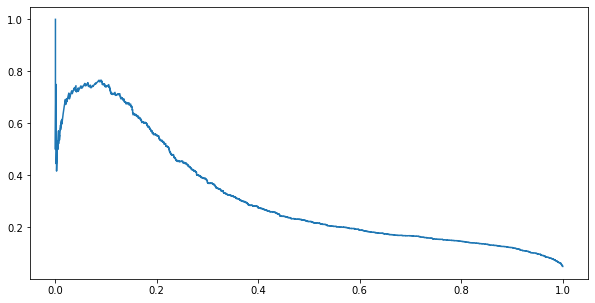

In [306]:
plt.plot(rec[:-1], prec[:-1])

In [307]:
f1 = 2*(np.array(rec)*np.array(prec)) / (np.array(rec) + np.array(prec))
f1 = np.nan_to_num(f1)

In [308]:
a = np.argmax(f1)
rec[a], prec[a], auc, f1[a]

(0.3121841661987647,
 0.36723910171730517,
 0.9895232292064545,
 0.33748103186646433)

In [309]:
model.load_state_dict(d["model"])

acc, model_sd = train_model(model, optimizer, nn.CrossEntropyLoss(), 30, train_arr, test_arr)

Train loss 0/7029: 0.0766913890838623
Train loss 1000/7029: 0.07099562198608429
Train loss 2000/7029: 0.05812588018336813
Train loss 3000/7029: 0.050071519043238234
Train loss 4000/7029: 0.04743486595165727
Train loss 5000/7029: 0.046599327558470925
Train loss 6000/7029: 0.044002179751056886
Train loss 7000/7029: 0.041239005712896834
Train loss 0/7029: 4.76837158203125e-06
Train loss 1000/7029: 0.01786387919426917
Train loss 2000/7029: 0.025723196979405463
Train loss 3000/7029: 0.027382890280784267
Train loss 4000/7029: 0.024002915626762808
Train loss 5000/7029: 0.02565008059808479
Train loss 6000/7029: 0.027130806019973246
Train loss 7000/7029: 0.02669990015462405
Train loss 0/7029: 0.0006384849548339844
Train loss 1000/7029: 0.026421988105678654
Train loss 2000/7029: 0.022867496745816354
Train loss 3000/7029: 0.0254817341951798
Train loss 4000/7029: 0.025471274605753182
Train loss 5000/7029: 0.024078052172873454
Train loss 6000/7029: 0.02526410082204603
Train loss 7000/7029: 0.025054

In [ ]:
acc_ft, auc_ft, prec_ft, rec_ft, thresh_ft = test_model(test_arr, model)

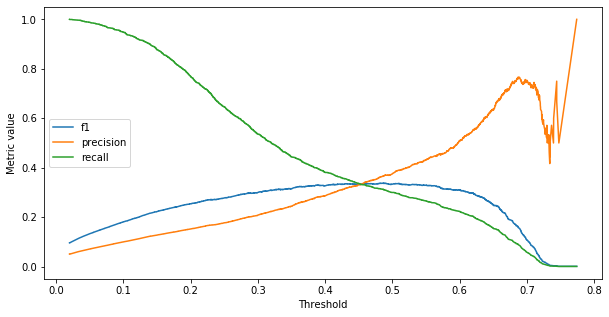

In [311]:
plt.plot(thresh, f1[:-1], label="f1")
plt.plot(thresh, prec[:-1], label="precision")
plt.plot(thresh, rec[:-1], label="recall")
plt.xlabel("Threshold")
plt.ylabel("Metric value")
plt.legend()

In [312]:
f1_ft = 2*(np.array(rec_ft)*np.array(prec_ft)) / (np.array(rec_ft) + np.array(prec_ft))
f1_ft = np.nan_to_num(f1_ft)

In [313]:
a = np.argmax(f1_ft)
rec_ft[a], prec_ft[a], auc_ft, f1_ft[a]

(0.7332959011791128,
 0.48298816568047337,
 0.9971995173536473,
 0.5823857302118172)

In [314]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

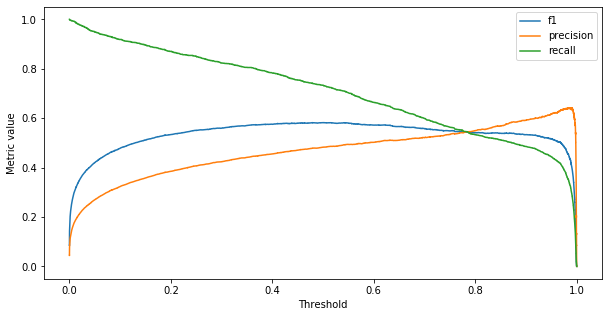

In [315]:
plt.plot(thresh_ft, f1_ft[:-1], label="f1")
plt.plot(thresh_ft, prec_ft[:-1], label="precision")
plt.plot(thresh_ft, rec_ft[:-1], label="recall")
plt.xlabel("Threshold")
plt.ylabel("Metric value")
plt.legend()

In [316]:
pretrained_ft = {"acc": acc_ft, "auc": auc_ft, "prec": prec_ft, "rec": rec_ft, "thresh": thresh_ft}
trained_only_gd1 = {"acc": acc, "auc": auc, "prec": prec, "rec": rec, "thresh": thresh}

In [317]:
import pickle

In [320]:
pickle.dump(pretrained_ft, open("pretrained_ft_70.p", "wb"))
pickle.dump(trained_only_gd1, open("trained_only_gd1_70.p", "wb"))

            

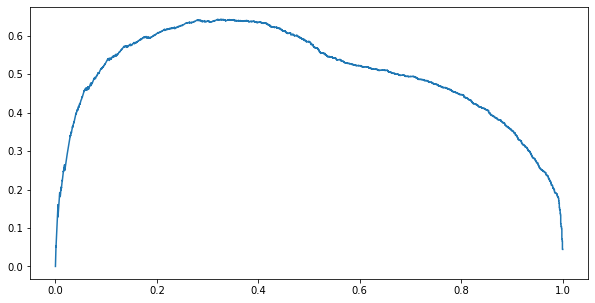

In [319]:
plt.plot(rec_ft[:-1], prec_ft[:-1])

In [8]:
k = 50
pretrained = pickle.load(open(f"pretrained_ft_{k}.p", "rb"))
trained_only = pickle.load(open(f"trained_only_gd1_{k}.p", "rb"))

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

In [11]:
d = pretrained

In [12]:
f1 = 2*(np.array(d["rec"])*np.array(d["prec"])) / (np.array(d["rec"]) + np.array(d["prec"]))
f1 = np.nan_to_num(f1)
a = np.argmax(f1)
d["rec"][a], d["prec"][a], d["auc"], f1[a]

(0.7417181358787198,
 0.5889433794025858,
 0.9976492893979675,
 0.6565606361829025)

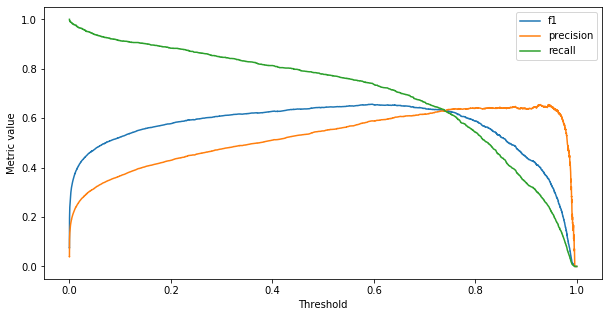

In [14]:
plt.plot(d["thresh"], f1[:-1], label="f1")
plt.plot(d["thresh"], d["prec"][:-1], label="precision")
plt.plot(d["thresh"], d["rec"][:-1], label="recall")
plt.xlabel("Threshold")
plt.ylabel("Metric value")
#plt.title("GD-1 results")
plt.legend()

In [228]:
d = trained_only

In [229]:
f1 = 2*(np.array(d["rec"])*np.array(d["prec"])) / (np.array(d["rec"]) + np.array(d["prec"]))
f1 = np.nan_to_num(f1)
a = np.argmax(f1)
d["rec"][a], d["prec"][a], d["auc"], f1[a]

(0.4918585064570466,
 0.32076162577810324,
 0.9923963992520366,
 0.3882978723404255)

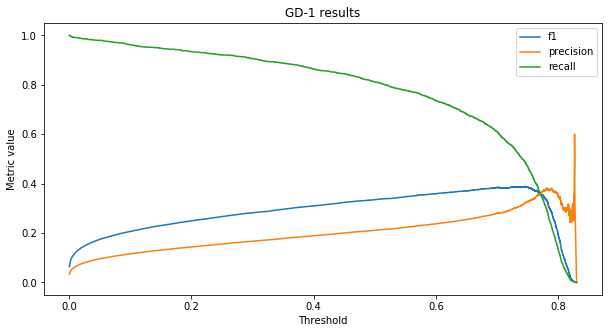

In [230]:
plt.plot(d["thresh"], f1[:-1], label="f1")
plt.plot(d["thresh"], d["prec"][:-1], label="precision")
plt.plot(d["thresh"], d["rec"][:-1], label="recall")
plt.xlabel("Threshold")
plt.ylabel("Metric value")
plt.title("GD-1 results")
plt.legend()

In [2]:
import matplotlib.pyplot as plt
import pickle

Text(0.5, 0, 'Recall')

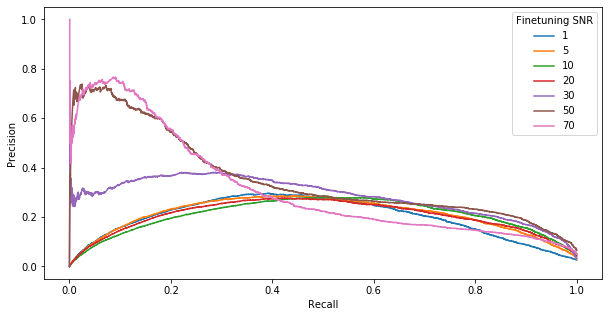

In [7]:
ks = [1, 5, 10, 20, 30, 50, 70]

for k in ks:
    pretrained = pickle.load(open(f"trained_only_gd1_{k}.p", "rb"))
    plt.plot(pretrained["rec"][:-1], pretrained["prec"][:-1], label=k)
    
plt.legend(title="Finetuning SNR", loc="upper right")
plt.ylabel("Precision")
plt.xlabel("Recall")

    